#### 1. Preparation

In [2]:
import os
os.getcwd()

'C:\\Users\\tmn52\\Grid_Orientation\\validation_002'

In [1]:
# This line of code is for accessing the virtual folder '\\file'
# I mapped the path to my virtual folder as S:\
# Reference: https://stackoverflow.com/questions/15514593/importerror-no-module-named-when-trying-to-run-python-script/15622021#15622021
import sys
sys.path.append(r'S:\Grid_Ori_bigdata_008')

In [2]:
# Packages
import os
import pathlib
import datetime

import numpy as np
import pandas as pd

import xarray as xr
import rioxarray as rxr
import rasterio as rio

import geopandas as gpd
from shapely.geometry import LineString, Point, MultiPoint

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set up main directory
main_dir = r"S:\Grid_Ori_bigdata_008"

In [4]:
resolution = 10

#### 2. Read DEM

Here, the DEM and roughness was coppied from 'dem' and 'roughness' folders to 'others' folder after generated

In [5]:
# If DEM needs clipping
# # Read DEM file
# dem_xr = xr.open_dataset(fr"{main_dir}\\dem.nc")

# # Assign crs
# dem_xr = dem_xr.rio.write_crs("epsg:2193", inplace=True)

# # Design cropping box
# clipped_geometry_domain =[
#     {
#         'type': 'Polygon',
#         'coordinates': [[
#             [1767791, 5471399],
#             [1767791, 5475880],
#             [1774510, 5475880],
#             [1774510, 5471399],
#             [1767791, 5471399]
#         ]]
#     }
# ]

# # Crop by geometry domain
# dem_xr_domain = dem_xr.z.rio.clip(clipped_geometry_domain)

In [6]:
# Read DEM file
dem_xr = xr.open_dataset(fr"{main_dir}\\dem.nc")

# Assign crs
dem_xr = dem_xr.rio.write_crs("epsg:2193", inplace=True)

# Crop by geometry domain
dem_xr_domain = dem_xr.z

#### 3. Roughness length to Manning's n

In [7]:
# If roughness needs clipping
# # Load zo - roughness length raster file
# zo_xr = xr.open_dataset(fr"{main_dir}\\zo.nc")

# # Assign crs
# zo_xr = zo_xr.rio.write_crs("epsg:2193", inplace=True)

# # Crop box
# geometry_roughness = [
#     {
#         'type': 'Polygon',
#         'coordinates': [[
#             [1767790, 5471400],
#             [1767790, 5475880],
#             [1774510, 5475880],
#             [1774510, 5471400],
#             [1767790, 5471400]
#         ]]
#     }
# ]

# # Crop by geometry domain
# zo_xr_domain = zo_xr.rio.clip(geometry_roughness)

# # Choose H=1 to obtain n
# n_domain = zo_to_n(zo_xr_domain, 1)

In [8]:
# Building up a function to convert roughness length (Z0) to Manning's n
def zo_to_n(zo, H):
    ''' This function is to convert roughness length (Z0) to Manning's n
    Ref: https://doi.org/10.1080/15715124.2017.1411923
    '''
    return (0.41 * (H**(1/6)) * ((H/zo) - 1))/(np.sqrt(9.80665) * (1 + (H/zo) * (np.log(H/zo) - 1)))

In [9]:
# Load zo - roughness length raster file
zo_xr = xr.open_dataset(fr"{main_dir}\\zo.nc")

# Assign crs
zo_xr = zo_xr.rio.write_crs("epsg:2193", inplace=True)

# Crop by geometry domain
zo_xr_domain = zo_xr.zo

# Choose H=1 to obtain n
n_domain = zo_to_n(zo_xr_domain, 1)

#### 3. Tide and flow

Flow and tidal data are extracted from [Greater Wellington Regional Council](http://graphs.gw.govt.nz/?siteName=Waikanae%20River%20at%20Water%20Treatment%20Plant&dataSource=Flow) from 5th to 6th Jan 2005 and [NIWA Tide Forecaster](https://tides.niwa.co.nz/416?latitude=-40.866&longitude=174.987&datum=MSL&interval=10&startDate=4172005-01-01&numberOfDay) respectively. They are then saved as 'csv' file and saved in 'others' folder.

In [10]:
## FLOW

# New Zealand time is 12 hours ahead Universal Time Coordinated --> UTC(0) and NZST(+12)
# So to convert back to UTC, the time needs to be converted back to New Zealand time
# http://graphs.gw.govt.nz/?siteName=Waikanae%20River%20at%20Water%20Treatment%20Plant&dataSource=Flow
flowJan2005 = pd.read_csv(fr"{main_dir}\\flow.csv", skiprows=[0], 
                          names=['DateChar', 'Flow', 'Quality'],
                          header=None)

# Get flow data
flowJan2005 = pd.read_csv(fr"{main_dir}\\flow.csv", names=['DateChar', 'Flow', 'Quality'], skiprows=[0], header=None)
flowJan2005 = flowJan2005[['DateChar', 'Flow']]

# Convert time data
flowJan2005['DateTime'] = pd.to_datetime(flowJan2005['DateChar'], format="%m/%d/%Y %H:%M:%S", utc=False)
flowJan2005['DateTime'] = flowJan2005['DateTime'].dt.tz_localize(None)

# Convert from NZST to UTC
time_change = datetime.timedelta(hours=12)
flowJan2005['DateTime'] = flowJan2005['DateTime'] - time_change

In [11]:
# Get tide data
tideJan2005 = pd.read_csv(fr"{main_dir}\\tide.csv",
                          skiprows=np.arange(0, 9, 1),
                          names=['DateChar', 'Level'],
                          header=None)
# Convert time data
tideJan2005['DateTime'] = pd.to_datetime(tideJan2005['DateChar'], format="%Y-%m-%dT%H:%M:%SZ", utc=False)
tideJan2005['DateTime'] = tideJan2005['DateTime'].dt.tz_localize(None) # Romve timezone

# Convert level data
tideJan2005['Level'] = tideJan2005['Level'] - 0.11

In [12]:
# Align flow and tide data
tide_flowJan2005 = pd.merge(tideJan2005, flowJan2005, how='outer', on='DateTime')[['DateTime', "Flow", "Level"]]
tide_flowJan2005 = tide_flowJan2005.sort_values(by='DateTime').reset_index(drop=True)
tide_flowJan2005['Level'] = tide_flowJan2005['Level'].interpolate(method='cubic')

# Select/Filter time
date_start = pd.to_datetime("2005-01-05 00:00:00")
date_end = pd.to_datetime("2005-01-07 00:00:00")

# Merge tide and flow
tide_flowJan2005 = tide_flowJan2005.loc[(tide_flowJan2005.DateTime >= "2005-01-05 00:00:00")
                                        & (tide_flowJan2005.DateTime <= "2005-01-07 00:00:00")]

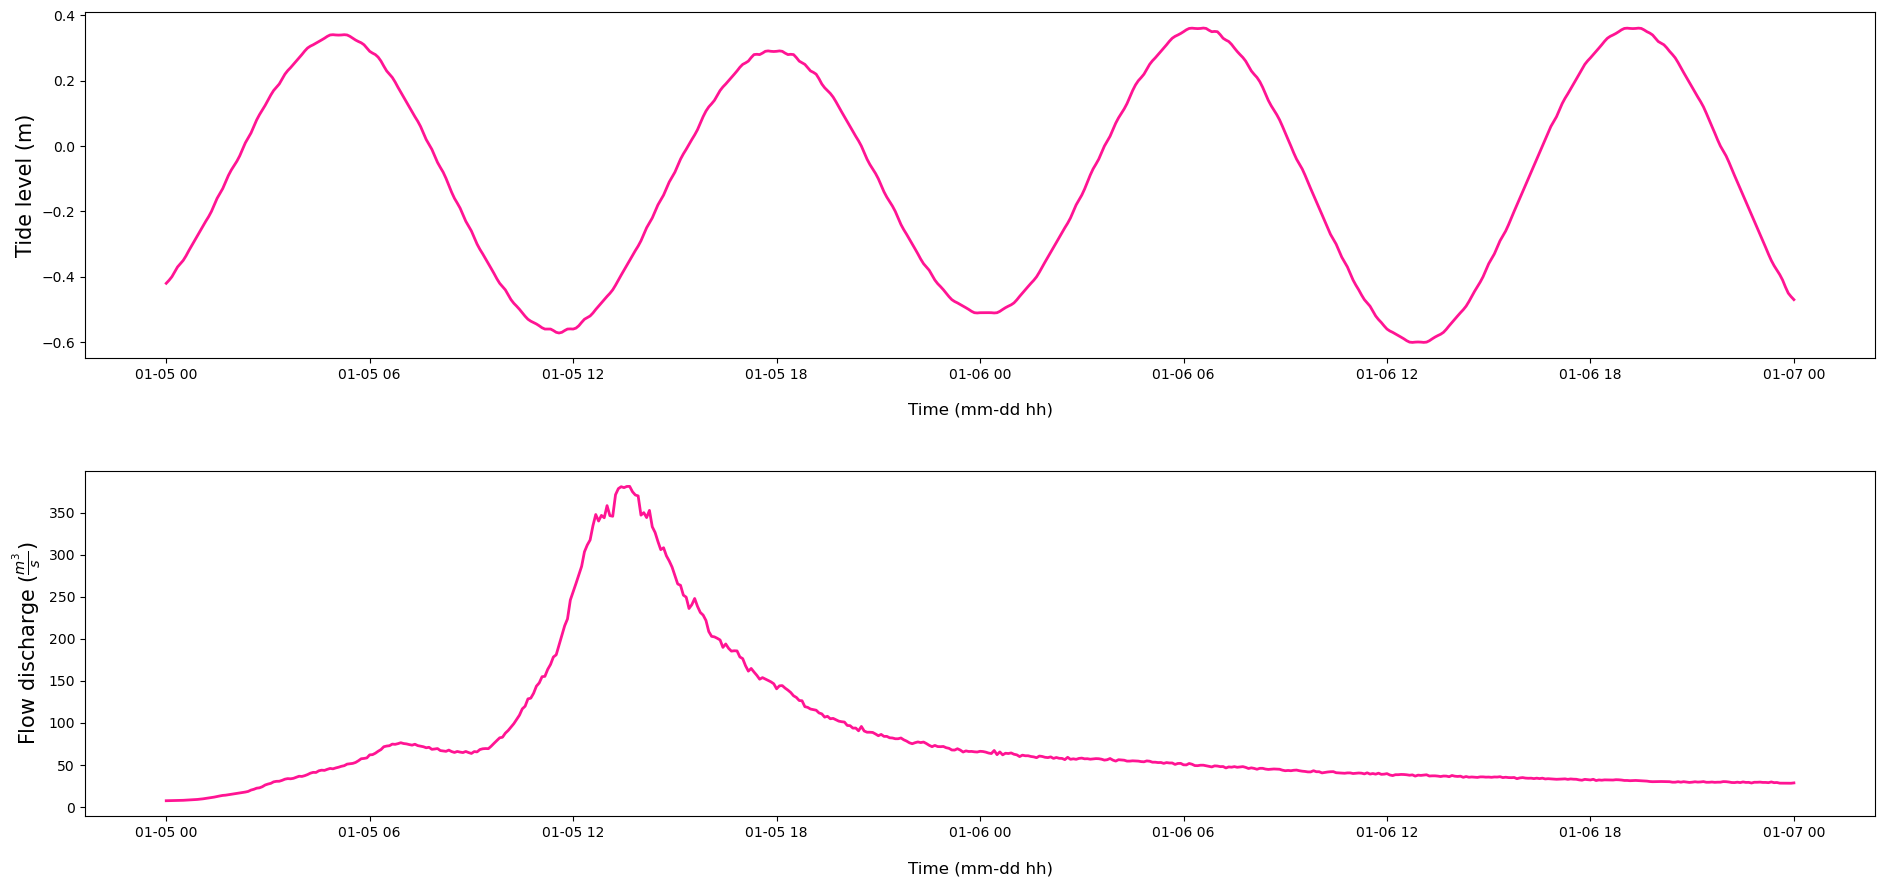

In [13]:
# Plot
fig, axes = plt.subplots(2, figsize=(20, 10))
fig.tight_layout(pad=6.0)

# Tide
axes[0].plot(tide_flowJan2005.DateTime, tide_flowJan2005.Level, linewidth=2, color='deeppink')
axes[0].set_xlabel('Time (mm-dd hh)', fontsize=12, labelpad=15)
axes[0].set_ylabel('Tide level (m)', fontsize=15)

# Flow
axes[1].plot(tide_flowJan2005.DateTime, tide_flowJan2005.Flow, linewidth=2, color='deeppink')
axes[1].set_xlabel('Time (mm-dd hh)', fontsize=12, labelpad=15)
axes[1].set_ylabel(r'Flow discharge ($\frac{m^{3}}{s}$)', fontsize=15)

# Save plots
plt.savefig(fr"{main_dir}\flow_tide", bbox_inches='tight', dpi=330)

#### 4. Startdepth

In [14]:
# Start file
startdepth = dem_xr_domain
startdepth = startdepth.where(startdepth.values <= tide_flowJan2005.Level.iloc[0], other=np.nan)
startdepth = startdepth * -1

#### 5. Sea

In [15]:
# Copy all files for easy manipulation without changing the originals
dem_xr_domain_copy = dem_xr_domain.copy(deep=True)
n_domain_copy = n_domain.copy(deep=True)
startdepth_copy = startdepth.copy(deep=True)

In [16]:
# Sea
seaarea = dem_xr_domain_copy * np.nan
seaarea = seaarea.where(dem_xr_domain_copy.values >= (np.min(tide_flowJan2005.Level)-3), other=1)

# Remove sea area
dem_xr_domain_copy = dem_xr_domain_copy.where(seaarea.values != 1, other=np.nan) # cropped DEM
n_domain_copy = n_domain_copy.where(seaarea.values != 1, other=np.nan) # Manning's n
startdepth_copy = startdepth.where(seaarea.values != 1, other=np.nan)

#### 6. Export rasters

In [17]:
# Write DEM
dem_xr_domain_copy = dem_xr_domain_copy.rio.write_nodata(-9999, inplace=True)
dem_xr_domain_copy.rio.to_raster(fr"{main_dir}\\dem_001.nc")
dem_xr_domain_copy = rxr.open_rasterio(fr"{main_dir}\\dem_001.nc")
dem_xr_domain_copy.rio.to_raster(fr"{main_dir}\\dem.asc")

# Write roughness
n_domain_copy = n_domain_copy.rio.write_nodata(-9999, inplace=True)
n_domain_copy.rio.to_raster(fr"{main_dir}\\n_001.nc")
n_domain_copy = rxr.open_rasterio(fr"{main_dir}\\n_001.nc")
n_domain_copy.rio.to_raster(fr"{main_dir}\\n.asc")

# Write startdepth
startdepth_copy = startdepth_copy.rio.write_nodata(-9999, inplace=True)
startdepth_copy.rio.to_raster(fr"{main_dir}\\startdepth_001.nc")
startdepth_copy = rxr.open_rasterio(fr"{main_dir}\\startdepth_001.nc")
startdepth_copy.rio.to_raster(fr"{main_dir}\\startdepth.asc")

#### 7. Tide points

Here, the file 'tideboundary.shp' was drawn using QGIS based on the generated DEM.

In [19]:
# Method 2: Create river points along the river line
tideboundary = gpd.read_file(fr"{main_dir}\\tideboundary.shp") # Read file
tideboundary_line = tideboundary.geometry[0]
tide_sampledis = 120
tide_num_points = 36 # Set up number of points
tidepoints = [tideboundary_line.interpolate((1/(tideboundary_line.length/tide_sampledis)) * i, normalized=True) for i in range(tide_num_points)] # Create a list comprehension to collect all coordinates of points 
tidepoints_geo = MultiPoint(tidepoints) # Gather all points into MultiPoint geometry

In [20]:
tideboundary_points = list(tidepoints_geo.geoms) # Method 2: List all points in MultiPoint
tideboundary_data = {'geometry': tideboundary_points}
tidepts = gpd.GeoDataFrame(data=tideboundary_data, crs="EPSG:2193")
tidepts.to_file(fr"{main_dir}\\tidepts.shp")

#### 8. Writing files

In [21]:
# Convert to seconds
tide_flowJan2005['seconds'] = pd.to_numeric(tide_flowJan2005.DateTime - np.min(tide_flowJan2005.DateTime))/(10**9)
tide_flowJan2005['seconds'] = tide_flowJan2005['seconds'].astype('int')

In [22]:
# Create discharge dataframe
flow_df = tide_flowJan2005[['Flow', 'seconds']].copy(deep=True)
flow_df['Flow'] = round(flow_df['Flow']/resolution, 4)
flow_df['seconds'] = flow_df['seconds'].astype(int) # ref: https://stackoverflow.com/questions/51865367/cannot-convert-the-series-to-class-int

# Create tide dataframe
tide_df = tide_flowJan2005[['Level', 'seconds']].copy(deep=True)
tide_df['Level'] = round(tide_df['Level'], 3)
tide_df['seconds'] = tide_df['seconds'].astype(int)

# Write BDY file - Flow file
with open(fr"{main_dir}\\waikanae.bdy", "w") as discharge_tide:
    # Write discharge
    discharge_note = "Waikanae LISFLOOD-FP setup\n"
    discharge_reference = discharge_note + "Waikanae\n"
    discharge_column_name = discharge_reference + '{0:<20}seconds\n'.format(tide_flowJan2005.Flow.shape[0])
    discharge_tide.write(discharge_column_name)
    for discharge_line in range(tide_flowJan2005.Flow.shape[0]):
        data_discharge = flow_df.iloc[discharge_line]
        text_river_discharge = '{0[0]:<20}{0[1]:.0f}\n'.format(data_discharge)
        discharge_tide.write(text_river_discharge)
    
    # Write tide
    tide_reference = 'Tide\n'
    tide_column_name = tide_reference + '{0:<20}seconds\n'.format(tide_flowJan2005.Level.shape[0])
    discharge_tide.write(tide_column_name)
    for tide_line in range(tide_flowJan2005.Level.shape[0]):
        data_tide = tide_df.iloc[tide_line]
        text_tide = '{0[0]:<20}{0[1]:.0f}\n'.format(data_tide)
        discharge_tide.write(text_tide)

In [23]:
# Injection point
injection = ['P', 1774477.413, 5471521.558, 'QVAR', 'Waikanae']

# Write BCI file - injection point and tide
with open(fr"{main_dir}\\waikanae.bci", "w") as boundary:
    injection_text = '{0[0]:<5}{0[1]:<20}{0[2]:<20}{0[3]:<7}{0[4]:<5}\n'.format(injection)
    boundary.write(injection_text)
    for line in range(tidepts.shape[0]):
        tide_boundary = ['P', int(round(tidepts.iloc[line][0].x, 0)), int(round(tidepts.iloc[line][0].y, 0)), 'HVAR', 'Tide']
        tide_text = '{0[0]:<5}{0[1]:<20}{0[2]:<20}{0[3]:<7}{0[4]:<5}\n'.format(tide_boundary)
        boundary.write(tide_text)

In [24]:
# Write PAR file - parameter file
# Create a list
parameters_list = [
    ('resroot', 'out'),
    ('dirroot', 'test_nearest'),
    ('saveint', 3600),
    ('massint', 100),
    ('sim_time', 172800),
    ('initial_tstep', 2),
    ('bcifile', 'waikanae.bci'),
    ('bdyfile', 'waikanae.bdy'),
    ('DEMFile', 'dem.asc'),
    ('manningfile', 'n.asc'),
    ('startfile', 'startdepth.asc'),
    ('dynamicrainfile', 'dynamicrain_nearest.nc')
]

# Write into array
parameters_array = np.array(parameters_list)

# Write into text file par format
with open(fr"{main_dir}\\waikanae.par", 'w') as parameters:
    for each_parameter in range(parameters_array.shape[0]):
        data_parameter = parameters_array[each_parameter]
        text_parameter = '{0[0]:<20}{0[1]}\n'.format(data_parameter)
        parameters.write(text_parameter)
    parameters.write('acceleration\ndrain_nodata\n\n')

In [26]:
# Create folder
pathlib.Path(fr"S:\Grid_Ori_bigdata_008\test_nearest").mkdir(parents=True, exist_ok=True)